### The performance metrics files need to be generated before running this.

In [1]:
%matplotlib notebook
import os
import csv
import numpy as np
from scipy.stats import norm
from scipy.stats import t as tdist
import matplotlib.pyplot as plt
import matplotlib
from context import *
from helpers.utils import load_perf_metrics, configure_plot_axes
from helpers.constants import *

In [2]:
def read_ber_ours(filename, snr_tar):
    ber_no_adapt = None
    ber_adapt = None
    with open(filename, 'r') as fp:
        cr = csv.reader(fp, delimiter=',')
        for i, row in enumerate(cr):
            if i == 0:
                # header
                continue

            snr = float(row[0])
            if abs(snr - snr_tar) < 1e-6:
                ber_no_adapt = float(row[3])
                ber_adapt = float(row[4])
                
    return ber_no_adapt, ber_adapt

In [3]:
def read_ber_finetune(filename, snr_tar):
    ber_no_adapt = None
    ber_adapt = None
    with open(filename, 'r') as fp:
        cr = csv.reader(fp, delimiter=',')
        for i, row in enumerate(cr):
            if i == 0:
                # header
                continue

            snr = float(row[0])
            if abs(snr - snr_tar) < 1e-6:
                ber_no_adapt = float(row[1])
                ber_adapt = float(row[2])
                
    return ber_no_adapt, ber_adapt

In [4]:
def read_ber_retrained(filename, snr_tar):
    snr_list_, ber_list_ = load_perf_metrics(filename)
    ber_retrained = None
    for s, b in zip(snr_list_, ber_list_):
        if abs(s - snr_tar) < 1e-6:
            ber_retrained = b
                
    return ber_retrained

In [5]:
base_dir = '/Users/jr/Documents/research/code/domain_adaptation/expts_icml22/autoencoder_new'
source_ch = 'AWGN'
source_snr = 14
target_ch = 'fading'
target_snr = 20
n_adapt_per_class = np.array([5, 10, 20, 30, 40, 50])
type1 = 'standard_iter'

metric_fname = 'ber_vs_snr_adaptation.csv'
plots_dir = os.path.join(base_dir, 'plots')
if not os.path.isdir(plots_dir):
    os.makedirs(plots_dir)

In [6]:
# Read the results of our adaptation method
ber_no_adapt = np.zeros(6)
ber_no_adapt1 = np.zeros(6)
ber_adapt1 = np.zeros(6)
for i, nad in enumerate(n_adapt_per_class):
    fname = os.path.join(base_dir, "{}_{:d}dB".format(source_ch, source_snr), 
                         "adapt_{}_{:d}".format(target_ch, nad), type1, metric_fname)
    ber_no_adapt1[i], ber_adapt1[i] = read_ber_ours(fname, target_snr)

ber_no_adapt += ber_no_adapt1

In [7]:
# Read the results of the fine-tuning baseline
ber_no_adapt3 = np.zeros(6)
ber_no_adapt4 = np.zeros(6)
ber_finetune = np.zeros(6)
ber_finetune_last = np.zeros(6)
for i, nad in enumerate(n_adapt_per_class):
    fname = os.path.join(base_dir, "{}_{:d}dB".format(source_ch, source_snr), 
                         "finetune_{}_{:d}".format(target_ch, nad), type1, metric_fname)
    ber_no_adapt3[i], ber_finetune[i] = read_ber_finetune(fname, target_snr)
    
    fname = os.path.join(base_dir, "{}_{:d}dB".format(source_ch, source_snr), 
                         "finetune_last_{}_{:d}".format(target_ch, nad), type1, metric_fname)
    ber_no_adapt4[i], ber_finetune_last[i] = read_ber_finetune(fname, target_snr)

ber_no_adapt += (ber_no_adapt3 + ber_no_adapt4)
ber_no_adapt /= 3.

In [8]:
# Read the performance of the retrained autoencoder on the target channel
fname = os.path.join(base_dir, "{}_{:d}dB".format(target_ch, target_snr), 'outputs', type1, 
                     'metrics_autoencoder.csv')
ber_retrained = read_ber_retrained(fname, target_snr) * np.ones(n_adapt_per_class.shape[0])


<IPython.core.display.Javascript object>


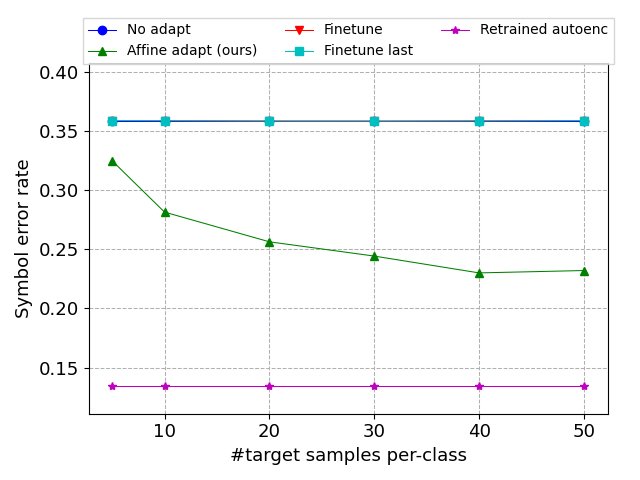

In [9]:
# Plot the symbol-error-rate vs number of target samples
fs = 13
fig = plt.figure()
y_vals = []
plt.plot(n_adapt_per_class, ber_no_adapt, linestyle='-', linewidth=0.75, color=COLORS[0], marker=POINT_STYLES[0],
         label='No adapt')
y_vals.extend(ber_no_adapt)

plt.plot(n_adapt_per_class, ber_adapt1, linestyle='-', linewidth=0.75, color=COLORS[1], marker=POINT_STYLES[1],
         label='Affine adapt (ours)')
y_vals.extend(ber_adapt1)

plt.plot(n_adapt_per_class, ber_finetune, linestyle='-', linewidth=0.75, color=COLORS[2], marker=POINT_STYLES[2],
         label='Finetune')
y_vals.extend(ber_finetune)

plt.plot(n_adapt_per_class, ber_finetune_last, linestyle='-', linewidth=0.75, color=COLORS[3], marker=POINT_STYLES[3],
         label='Finetune last')
y_vals.extend(ber_finetune_last)

plt.plot(n_adapt_per_class, ber_retrained, linestyle='-', linewidth=0.75, color=COLORS[4], marker=POINT_STYLES[4],
         label='Retrained autoenc')
y_vals.extend(ber_retrained)

# plt.yscale('log')
# Increase the upper y-limit a bit
y_bot, y_top = plt.ylim()
plt.ylim((0.9 * y_bot, 1.1 * y_top))

plt.xlabel('#target samples per-class', fontsize=fs, fontweight='normal')
plt.ylabel('Symbol error rate', fontsize=fs, fontweight='normal')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
# plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
plt.grid(True, axis='both', linestyle='dashed', linewidth=0.75, alpha=1.)
# plt.legend(loc='best')
plt.legend(loc='upper center', frameon=True, bbox_to_anchor=(0.5, 1.15), ncol=3, 
           fontsize=10, fancybox=False)

# Save the figure
fig.tight_layout()
plot_filename = os.path.join(plots_dir, 'plot_{}_{:d}dB__to__{}_{:d}dB'.
                             format(source_ch, source_snr, target_ch, target_snr))
fig.savefig(plot_filename + '.png', dpi=600, bbox_inches='tight')
fig.savefig(plot_filename + '.pdf', dpi=600, bbox_inches='tight')
plt.show()